In [9]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [10]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

## Histogram Matching

In [11]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, image_folder, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

In [12]:
### Extract mean histogram from the training dataset
np.save('mean_hist.npy', mean_histogram)

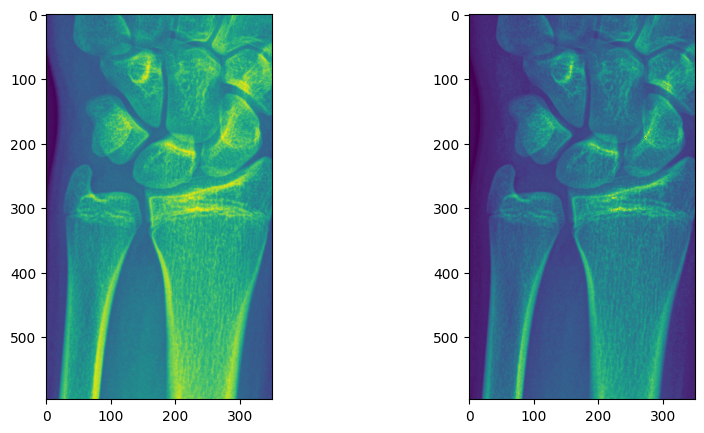

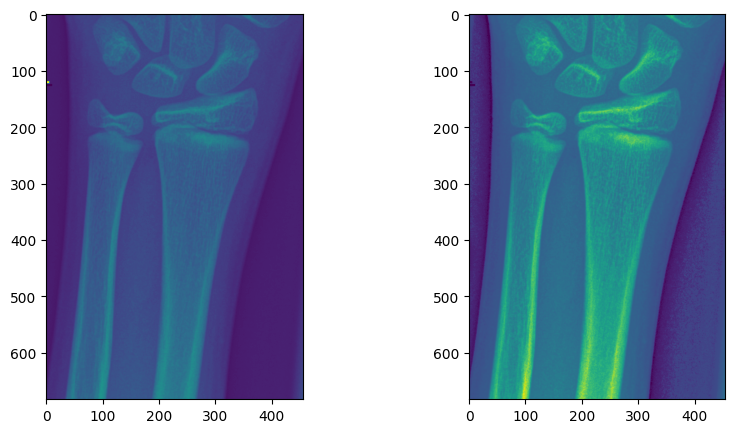

In [4]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [5]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [6]:
def process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, fracture=True):
    """
    Processes an image by preprocessing and loading corresponding labels.

    Args:
    image_path (str): Path to the image file.
    root_path (str): Base path for data.
    label_folder (str): Folder containing label files.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.
    unsharp (bool): Flag for unsharp mask processing.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    labels = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if fracture:
        ### Parse label
        image_name = os.path.basename(image_path)
        label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
        labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth, unsharp=unsharp)
    
    return img, labels

## Extract Features

In [7]:
windowSize = 256
stepSize = 128 
# Parameters for LBP
num_points = 16  # Typically 8, 16, or 24
radius = 7       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [8]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
unsharp = True # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

In [9]:
num_features = 300
show_grid = False

In [19]:
### Extract LBP features and export to npy file
mode = 'test'
class_name = 'fracture'
export_path_fracture = os.path.join(root_path, f'{mode}_{class_name}_lbp.npy')
export_path_non_fracture = os.path.join(root_path, f'{mode}_non_{class_name}_lbp.npy')
export_path_normal = os.path.join(root_path, f'{mode}_normal_lbp.npy')

fracture_features = []
non_fracture_features = []

### Local Binary Pattern
lbp = LBP(num_points, radius)
### Histogram of Oriented Gradients
hog = cv2.HOGDescriptor()

### Loop through all images
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    print(f"Processing {image_path}")
    if len(fracture_features) >= num_features and len(non_fracture_features) >= num_features:
        break
    
    ### Extract LBP features
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, fracture=True if class_name == 'fracture' else False)
    image = draw_bboxes(image, labels)
    
    # Use sliding window to generate windows
    windows = list(sliding_window(image, stepSize=stepSize, windowSize=windowSize))
    num_windows = len(windows)
    
    if show_grid:
        # Determine the grid size
        grid_size = int(np.ceil(np.sqrt(num_windows)))
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    for i, (x, y, window_img) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_img.shape[0] != windowSize or window_img.shape[1] != windowSize:
            continue
        # ## Image histogram 
        # hist, bins = np.histogram(window_img.flatten(), bins=256, range=[0, 256])
        # lbp_features = lbp.get_lbp_image(window_img)
        hog_features = hog.compute(window_img)
        # lbp_features = lbp_features.ravel()
        hog_features = hog_features.ravel()
        
        # combined_features = np.concatenate([lbp_features, hog_features])
        # combined_features = combined_features.astype(np.float32)
        
        is_fracture = False
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                if len(fracture_features) < num_features:
                    fracture_features.append(hog_features)
                is_fracture = True
                break
        if show_grid:
            # Plot the window
            ax[i // grid_size, i % grid_size].imshow(window_img, cmap='gray')
            ax[i // grid_size, i % grid_size].title.set_text(str(iou_score) + ' ' + str(is_fracture))
            # ax[i // grid_size, i % grid_size].axis('off')
    
        if is_fracture == False:
            non_fracture_features.append(hog_features)
            
    if show_grid:
        # Turn off any unused subplots
        for j in range(i + 1, grid_size * grid_size):
            ax[j // grid_size, j % grid_size].title.set_text('Unused')
            # ax[j // grid_size, j % grid_size].axis('off')
        
        plt.show()
        if idx > 10:
            break

Processing MLDataset/crop_data/images/test/fracture/0078_1212376663_01_WRI-L2_M011.png
Processing MLDataset/crop_data/images/test/fracture/0249_1109609409_01_WRI-R1_M001.png
Processing MLDataset/crop_data/images/test/fracture/0190_0855090520_01_WRI-R1_M013.png
Processing MLDataset/crop_data/images/test/fracture/0014_0516192868_01_WRI-L2_M006.png
Processing MLDataset/crop_data/images/test/fracture/0059_0828268006_02_WRI-R2_M010.png
Processing MLDataset/crop_data/images/test/fracture/0086_0262776901_01_WRI-L2_F008.png
Processing MLDataset/crop_data/images/test/fracture/0033_1098977682_01_WRI-L2_F006.png
Processing MLDataset/crop_data/images/test/fracture/0078_1215384180_05_WRI-L1_M011.png
Processing MLDataset/crop_data/images/test/fracture/0133_0281744388_01_WRI-R1_M014.png
Processing MLDataset/crop_data/images/test/fracture/0142_0856460514_01_WRI-L2_M007.png
Processing MLDataset/crop_data/images/test/fracture/0323_0227289784_01_WRI-R1_F005.png
Processing MLDataset/crop_data/images/test/

In [13]:
### Export to npy file normal
np.save(export_path_normal, np.array(non_fracture_features[:num_features]))

In [20]:
### Export to npy file fracture and non-fracture
np.save(export_path_fracture, fracture_features)
np.save(export_path_non_fracture, non_fracture_features[:num_features])

## Machine Learning Model

### Load data

In [3]:
dataset_path = 'MLDataset/crop_data'

In [5]:
train_normal_features = np.load(os.path.join(dataset_path, 'train_normal_lbp.npy'))[:100]
train_non_fracture = np.load(os.path.join(dataset_path, 'train_non_fracture_lbp.npy'))[:100]
train_non_fracture_features = np.concatenate([train_normal_features, train_non_fracture])

train_fracture_features = np.load(os.path.join(dataset_path, 'train_fracture_lbp.npy'))[:200]
train_features = np.concatenate([train_non_fracture_features, train_fracture_features])
train_labels = np.array([0] * len(train_non_fracture_features) + [1] * len(train_fracture_features))

In [16]:
## Histogram of LBP features
train_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in train_features]
test_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in test_features]

In [9]:
import random
random.shuffle(list(range(len(train_features))))

train_features = train_features
train_labels = train_labels

# test_features = test_features
# test_labels = test_labels

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

### Training

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
model = SVC(kernel='linear')
# model = RandomForestClassifier(n_estimators=00, random_state=42, class_weight='balanced')
# model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.86      0.78      0.82        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80

[[35  5]
 [ 9 31]]
f1-score: 0.8245614035087719


## Export the model

In [4]:
model_path = 'models/weights/svm.pkl'

In [14]:
### Export model
joblib.dump(model, model_path)

['models/weights/svm.pkl']

## Load the model

In [5]:
model = joblib.load(model_path)

## Testing

In [6]:
test_normal_features = np.load(os.path.join(dataset_path, 'test_normal_lbp.npy'))[:200]
test_non_fracture = np.load(os.path.join(dataset_path, 'test_non_fracture_lbp.npy'))
test_non_fracture_features = np.concatenate([test_normal_features, test_non_fracture])

test_fracture_features = np.load(os.path.join(dataset_path, 'test_fracture_lbp.npy'))
test_features = np.concatenate([test_non_fracture_features, test_fracture_features])
test_labels = np.array([0] * len(test_non_fracture_features) + [1] * len(test_fracture_features))

In [8]:
# Evaluate the model on the valid set
y_pred_test = model.predict(test_features)
print(classification_report(test_labels, y_pred_test))
print(confusion_matrix(test_labels, y_pred_test))
print('f1-score:', f1_score(test_labels, y_pred_test, average='weighted'))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       500
           1       0.74      0.76      0.75       300

    accuracy                           0.81       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.81      0.81      0.81       800

[[420  80]
 [ 73 227]]
f1-score: 0.8091786658172279


(-0.5, 999.5, 999.5, -0.5)

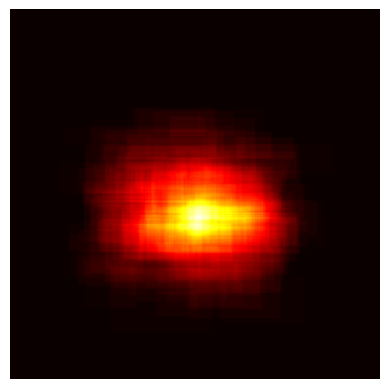

In [13]:
heatmap = np.load('./heatmap.npy')
coords = np.column_stack(np.where(heatmap > 0))
top_left = coords.min(axis=0)
bottom_right = coords.max(axis=0)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')

In [20]:
from utils.vis import draw_bboxes

image_files = glob.glob(os.path.join(root_path, 'test/**/*.png'), recursive=True)

## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if 'fracture' not in image_file:
        continue
    print(f"Processing {image_file}")
    ### Parse label
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image_name = os.path.basename(image_file)
    label_path = os.path.join(root_path, label_folder, image_name.replace('.png', '.txt'))
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    draw_bboxes(image, labels)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]

    _, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image, cmap='gray')
    fig[0].axis('off')
    fig[1].imshow(roi_image, cmap='gray')
    fig[1].axis('off')
    
    plt.show()

In [17]:
from utils.vis import draw_bboxes

crop_data_path = os.path.join(root_path, 'crop_data/images')
mode = 'train'
save_path = os.path.join(crop_data_path, mode)

image_files = glob.glob(os.path.join(root_path, image_folder, mode, '**/*.png'), recursive=True)


## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    print(f"Processing {image_file}")
    ### Parse label
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image_name = os.path.basename(image_file)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]
    
    ## Save the cropped image
    class_name = image_file.split('/')[-2]
    os.makedirs(os.path.join(save_path, class_name), exist_ok=True)
    cv2.imwrite(os.path.join(os.path.join(save_path, class_name), image_name), roi_image)
    
    if 'normal' in image_file:
        continue
    label_path = image_file.replace('images', 'labels').replace('.png', '.txt')
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    ## Rescale the labels to cropped image
    new_labels = []
    for label in labels:
        c, *xyxy = label
        x1, y1, x2, y2 = xyxy
        roi_x1, roi_y1, roi_x2, roi_y2 = x1-scaled_roi_coords[1], y1-scaled_roi_coords[0], x2-scaled_roi_coords[1], y2-scaled_roi_coords[0]
        # new_labels.append([c, roi_x1, roi_y1, roi_x2, roi_y2])
        roi_h, roi_w = roi_image.shape
        norm_x1, norm_y1, norm_x2, norm_y2 = roi_x1/roi_w, roi_y1/roi_h, roi_x2/roi_w, roi_y2/roi_h
        norm_xc, norm_yc = (norm_x1 + norm_x2)/2, (norm_y1 + norm_y2)/2
        norm_w, norm_h = norm_x2 - norm_x1, norm_y2 - norm_y1
        new_labels.append([c, norm_xc, norm_yc, norm_w, norm_h])
    
    # draw_bboxes(roi_image, new_labels)
    ## Export new labels
    save_label_path = save_path.replace('images', 'labels')
    os.makedirs(os.path.join(save_label_path, class_name), exist_ok=True)
    new_label_path = os.path.join(save_label_path, class_name, image_name.replace('.png', '.txt'))
    f = open(new_label_path, 'w')
    for label in new_labels:
        f.write(f"{label[0]} {label[1]} {label[2]} {label[3]} {label[4]}\n")
    f.close()

    # _, fig = plt.subplots(1, 2, figsize=(10, 5))
    # fig[0].imshow(image, cmap='gray')
    # fig[0].axis('off')
    # fig[1].imshow(roi_image, cmap='gray')
    # fig[1].axis('off')

Processing MLDataset/images/train/normal/0295_0511660026_01_WRI-L1_F015.png
Processing MLDataset/images/train/normal/0159_1276861687_01_WRI-L1_M013.png
Processing MLDataset/images/train/normal/0251_0732110286_01_WRI-L2_M010.png
Processing MLDataset/images/train/normal/0114_0838457189_01_WRI-L1_F010.png
Processing MLDataset/images/train/normal/0154_1139950395_03_WRI-R1_M011.png
Processing MLDataset/images/train/normal/0188_0212411736_01_WRI-L1_M012.png
Processing MLDataset/images/train/normal/1778_1324516348_01_WRI-L2_M009.png
Processing MLDataset/images/train/normal/0266_0382651447_01_WRI-R1_F012.png
Processing MLDataset/images/train/normal/1557_0312275546_01_WRI-L1_M011.png
Processing MLDataset/images/train/normal/0161_0809821041_01_WRI-R2_M015.png
Processing MLDataset/images/train/normal/0153_0319273069_01_WRI-R2_M016.png
Processing MLDataset/images/train/normal/1692_0545940912_01_WRI-L1_F010.png
Processing MLDataset/images/train/normal/0118_0296477953_01_WRI-L1_F014.png
Processing M